## Paweł Fijałkowski
### Wstęp do uczenia maszynowego - praca domowa 4
#### MiNI PW

#### Importy

In [9]:
from sklearn.datasets import load_wine
from dalex.datasets import load_apartments
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import dalex as dx


#### Zbiór danych: `load_apartments`

In [10]:
apartments = load_apartments()

In [11]:
apartments.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


In [12]:
apartments_data = apartments.drop('m2_price', axis=1)
apartments_predict = apartments.m2_price

In [14]:
apartments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   construction_year  1000 non-null   int64 
 1   surface            1000 non-null   int64 
 2   floor              1000 non-null   int64 
 3   no_rooms           1000 non-null   int64 
 4   district           1000 non-null   object
dtypes: int64(4), object(1)
memory usage: 46.9+ KB


In [16]:
apartments_predict

1       5897
2       1818
3       3643
4       3517
5       3013
        ... 
996     6355
997     3422
998     3098
999     4192
1000    3327
Name: m2_price, Length: 1000, dtype: int64

<AxesSubplot:>

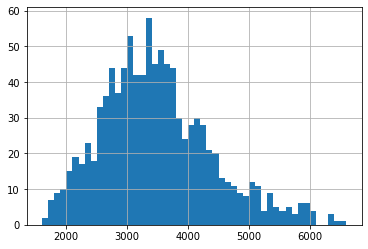

In [20]:
apartments_predict.hist(bins = 50)

Widzimy więc, że jest to problem regresji na zmiennej o rozkładzie przypominającym pozytywnie skośny.

In [27]:
transformer_ohe = make_column_transformer(
    (OneHotEncoder(), ['district']), remainder='passthrough')
transformer_ohe_scaler_std = preprocess_apartments_scaled = make_column_transformer(
    (OneHotEncoder(), ['district']), remainder=StandardScaler())

In [28]:
X_apart_train, X_apart_test, y_apart_train, y_apart_test = train_test_split(
    apartments_data, apartments_predict, test_size=0.42, random_state=37)

In [80]:
def fit_model(transformer, model, x , y):
    object_model = make_pipeline(transformer,model())
    object_model.fit(x, y)
    return object_model

In [91]:
apart_model_simple = fit_model(transformer_ohe, SVR, X_apart_train, y_apart_train)
apart_model_scaled = fit_model(transformer_ohe_scaler_std, SVR, X_apart_train, y_apart_train)

In [96]:
def rmse(model, y, x):
    return np.sqrt(mse(y, model.predict(x)))

In [95]:
def compare_models(model1, model2, x, y):
    rmse_model1 = rmse(model1,y, x)
    rmse_model2 = rmse(model2,y, x)

    print(f"Model1 rmse: {rmse_model1}")
    print(f"Model2 rmse: {rmse_model2}")
    
    improvement = 100*(rmse_model2 - rmse_model1)/(rmse_model1)
    print(f"Improvement: {improvement}%")

In [53]:
compare_models(apart_model_simple,apart_model_scaled, X_apart_test,y_apart_test)

Model1 rmse: 884.2508926958528
Model2 rmse: 865.98407301113
Improvement: -2.065796012829796%


Dobieramy siatkę dyskretną parametrów na podstawie podlinkowanego artykułu.


In [54]:
svr_param_grid = {
    'svr__gamma':2 ** np.linspace(-10, 10, 10),
    'svr__C':2 ** np.linspace(-10, 10, 10),
    'svr__degree': [2, 3, 4, 5]
}

def get_best_model(model, params_grid, n_iter, X, Y):
    rscv = RandomizedSearchCV(model, params_grid,
                               scoring ='neg_root_mean_squared_error', n_iter=n_iter, n_jobs=-1)

    rscv.fit(X, Y)
    
    return rscv.best_estimator_

In [55]:
apart_model_simple_tuned = get_best_model(apart_model_simple,svr_param_grid, 40, X_apart_test, y_apart_test)
apart_model_scaled_tuned = get_best_model(apart_model_scaled,svr_param_grid, 40, X_apart_test, y_apart_test)

In [56]:
compare_models(apart_model_simple_tuned, apart_model_scaled_tuned, X_apart_test, y_apart_test)

Model1 rmse: 667.0881206572817
Model2 rmse: 217.29167403162685
Improvement: -67.42684102701013%


Widzimy więc znaczącą poprawę w dokładności naszej predykcji (dopasowywując hiperparametry, w szczególności w przypadku skalowania).

#### Zbiór danych: `load_wine`

In [65]:
wine_data = load_wine(as_frame=True)["data"]
wine_target = load_wine(as_frame=True)["target"]

In [66]:
wine_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [69]:
wine_target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

<AxesSubplot:>

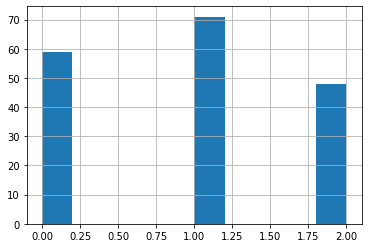

In [70]:
wine_target.hist()

Mamy więc doczynienia z problemem klasyfikacji na zbiorze o wielu zmiennych liczbowych (zgodnie z zaleceniami polecenia). 

Zauważmy też, że klasy są porównywalnej wielkości.

In [100]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
    wine_data, wine_target, test_size=0.3, random_state=37)

wine_model_simple = SVC().fit(X_wine_train, y_wine_train)
wine_model_scaled = fit_model(StandardScaler(), SVC, X_wine_train, y_wine_train)

In [111]:
def compare_models_f1(model1, model2, x, y):
    f1_m1 = f1_score(y, model1.predict(x),average = 'macro')
    f1_m2 = f1_score(y, model2.predict(x),average = 'macro')

    print(f"Model1 f1: {f1_m1}")
    print(f"Model2 f1: {f1_m2}")
    
    improvement = 100*(f1_m2 - f1_m1)/(f1_m1)
    print(f"Improvement: {improvement}%")

In [113]:
compare_models_f1(wine_model_simple,wine_model_scaled,X_wine_train,y_wine_train)

Model1 f1: 0.7286450521133802
Model2 f1: 1.0
Improvement: 37.24103349080258%


Na pierwszy rzut oka, możemy pomyśleć że w tym przypadku `Standard Scaler` zrobił niesamowitą pracę i doprowadził nas do "modelu idealnego" - zawsze poprawnego. Tak oczywiście jednak nie jest i oznacza to, że w przypadku porównywalnych mocami zbiorów możliwych przydziałów klasyfikacyjnych, skalowanie `normalne` nie ma sensu.

Jest to pouczający przykład, pomimo powierzchownego zapędzenia się w tzw. kozi róg.

## Wnioski

1. Odpowiednie skalowanie zmiennych w modelu `SVM` jest bardzo istotne. 
2. Właściwy dobór hiperparametrów znacząco wpływa na `performance` modelu.

Wymienione cechy `SVM` stanowią jego wadę jak i zaletę, ponieważ taka charakterystyka wymaga od analityka/programisty dodatkowej pracy eksperymentalnej w znalezieniu "tego jedynego skalowania/zestawu skalowań"